In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import random
import sys; sys.path.insert(0, '../dpsom/')

from TempDPSOM import get_data_finance

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [52]:
data_train, data_eval, labels_train, labels_eval = get_data_finance(finance_data_path="../data/yf_basic_price_features.p", 
                                                                    N_companies_train=400, 
                                                                    T_finance_data=144, 
                                                                    scale_fin_data=StandardScaler())

In [53]:
EXP_NAME = 'hyperopt_LSTM_5_2-2_2021-03-19_4317f'
tdpsom_dict = pickle.load(open('../logs/{}/output.p'.format(EXP_NAME), 'rb'))

## 1) initial look at the results

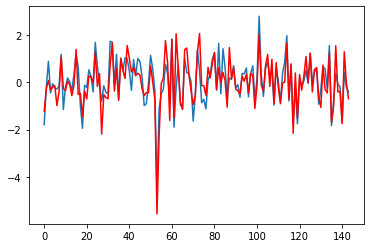

In [73]:
plt.plot(np.reshape(tdpsom_dict["x_rec_train"], (-1, 144, 7))[1, :, 0])
plt.plot(data_train[1, :, 0], color='red')
plt.show()

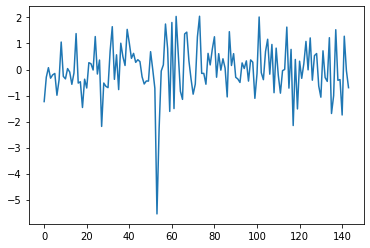

In [55]:
plt.plot(data_train[1, :, 0])

In [62]:
unique, counts = np.unique(tdpsom_dict["k_train"], return_counts=True)

In [63]:
unique

array([0, 1, 2, 3], dtype=int64)

In [64]:
counts

array([ 4462,  2604,  2560, 42214], dtype=int64)

In [65]:
unique, counts = np.unique(tdpsom_dict["k_eval"], return_counts=True)

In [66]:
unique

array([0, 1, 2, 3], dtype=int64)

In [67]:
counts

array([1005,  536,  613, 9366], dtype=int64)

## 2) compute metrics

In [78]:
def compute_metrics(data_train, data_eval, save_dict, N_companies=4, seed=42, T=144, pred_steps=10, som_grid=[2,2]):
    
    results = {}
        
    # due to strange implementation of batching in T-DPSOM
    N_train = int(len(save_dict["x_rec_train"]) / T)
    N_eval = int(len(save_dict["x_rec_eval"]) / T)
    data_train = data_train[:N_train].copy()
    data_eval = data_eval[:N_eval].copy()
    nr_features = data_train.shape[-1]
    
    # reconstruction loss
    x_rec_train = np.reshape(save_dict["x_rec_train"], (-1, T, nr_features))
    x_rec_eval = np.reshape(save_dict["x_rec_eval"], (-1, T, nr_features))
    results["recon_MSE_train"] = round(mean_squared_error(np.reshape(data_train, -1), np.reshape(x_rec_train, -1)), 4)
    results["recon_MSE_eval"] = round(mean_squared_error(np.reshape(data_eval, -1), np.reshape(x_rec_eval, -1)), 4)
    results["recon_MSE_train_returns"] = round(mean_squared_error(np.reshape(data_train[:, :, 0], -1), np.reshape(x_rec_train[:, :, 0], -1)), 4)
    results["recon_MSE_eval_returns"] = round(mean_squared_error(np.reshape(data_eval[:, :, 0], -1), np.reshape(x_rec_eval[:, :, 0], -1)), 4)
    
    # pred loss
    data_train_pred = data_train[:, 1:, :]  # shift
    data_eval_pred = data_eval[:, 1:, :]  # shift
    data_eval_pred = data_eval[:, -pred_steps:, :]  # consider only last part of time-series for LSTM preds 
    data_train_pred = data_train_pred[:, -pred_steps:, :]  # consider only last part of time-series for LSTM preds 
    x_preds_train = np.reshape(save_dict["x_preds_train"], (-1, T, nr_features))[:, :-1, :]  # shift
    x_preds_eval = np.reshape(save_dict["x_preds_eval"], (-1, T, nr_features))[:, :-1, :]  # shift
    x_preds_train = x_preds_train[:, -pred_steps:, :]  # consider only last part of time-series for LSTM preds 
    x_preds_eval = x_preds_eval[:, -pred_steps:, :]  # consider only last part of time-series for LSTM preds 
    
    results["preds_MSE_train"] = round(mean_squared_error(np.reshape(data_train_pred, -1), np.reshape(x_preds_train, -1)), 4)
    results["preds_MSE_eval"] = round(mean_squared_error(np.reshape(data_eval_pred, -1), np.reshape(x_preds_eval, -1)), 4) 
    results["preds_MSE_train_returns"] = round(mean_squared_error(np.reshape(data_train_pred[:, :, 0], -1), np.reshape(x_preds_train[:, :, 0], -1)), 4)
    results["preds_MSE_eval_returns"] = round(mean_squared_error(np.reshape(data_eval_pred[:, :, 0], -1), np.reshape(x_preds_eval[:, :, 0], -1)), 4)
    
    # clustering train
    clusters_train, clusters_size_train = np.unique(save_dict["k_train"], return_counts=True)
    nr_clusters = som_grid[0] * som_grid[1]
    results["clusters_train"] = (len(clusters_train), nr_clusters)
    for i, k in enumerate(clusters_train):
        results["cluster_{}".format(k)] = clusters_size_train[i]
    
    # clustering eval
    # TODO
      
    return results

In [80]:
compute_metrics(data_train, data_eval, tdpsom_dict)

{'recon_MSE_train': 0.8471,
 'recon_MSE_eval': 0.8495,
 'recon_MSE_train_returns': 0.4281,
 'recon_MSE_eval_returns': 0.4291,
 'preds_MSE_train': 1.8812,
 'preds_MSE_eval': 2.021,
 'preds_MSE_train_returns': 1.9417,
 'preds_MSE_eval_returns': 2.0669,
 'clusters_train': (4, 4),
 'cluster_0': 4462,
 'cluster_1': 2604,
 'cluster_2': 2560,
 'cluster_3': 42214}

## 3) plot recons/preds

In [20]:
def plot_tdpsom_results(data_train, data_eval, EXP_NAME, N_companies=4, seed=42, T=144, pred_steps=10):
    
    save_dict = pickle.load(open('../logs/{}/output.p'.format(EXP_NAME), 'rb'))
    
    
    # select companies for plotting
    N_train = int(len(save_dict["x_rec_train"]) / T)
    N_eval = int(len(save_dict["x_rec_eval"]) / T)
    nr_features = data_train.shape[2]
    
    random.seed(seed)
    train_companies = [(i, "train") for i in random.sample(list(range(N_train)), N_companies)]
    eval_companies = [(i, "eval") for i in random.sample(list(range(N_eval)), N_companies)]
    companies = train_companies + eval_companies

    for i, mode in companies:
        
        print("=================================== {}, company {} ====================================".format(mode, i))
        fig, axs = plt.subplots(nr_features, 3, figsize=(20, 5 * nr_features))

        if mode == "train":
            x = data_train[i]
        else:
            x = data_eval[i]
            
        x_rec = np.reshape(save_dict["x_rec_{}".format(mode)], (-1, T, nr_features))[i]
        x_preds = np.reshape(save_dict["x_preds_{}".format(mode)], (-1, T, nr_features))[i]
        k = np.reshape(save_dict["k_{}".format(mode)], (-1, T))[i]
        
        for j in range(nr_features):
            axs[j, 0].plot(x_rec[:, j], color="red", label="recons")
            axs[j, 0].plot(x[:, j], color="blue", label="ground-truth")
            axs[j, 0].set_title("Reconstructions, company {}-{}, feature {}".format(mode, i, j))

            preds = x_preds[:-1, j][-pred_steps:]
            ground_truths = x[1:, j][-pred_steps:]
            axs[j, 1].plot(preds, color="red", label="preds")
            axs[j, 1].plot(ground_truths, color="blue", label="ground-truth")
            axs[j, 1].set_title("Predictions, company {}-{}, feature {}".format(mode, i, j))
            
            axs[j, 2].plot(k)
            axs[j, 2].set_title("Clusters, company {}-{}".format(mode, i))
            
        plt.show()
    
    return train_companies, eval_companies

=================================== train, company 327 ====================================


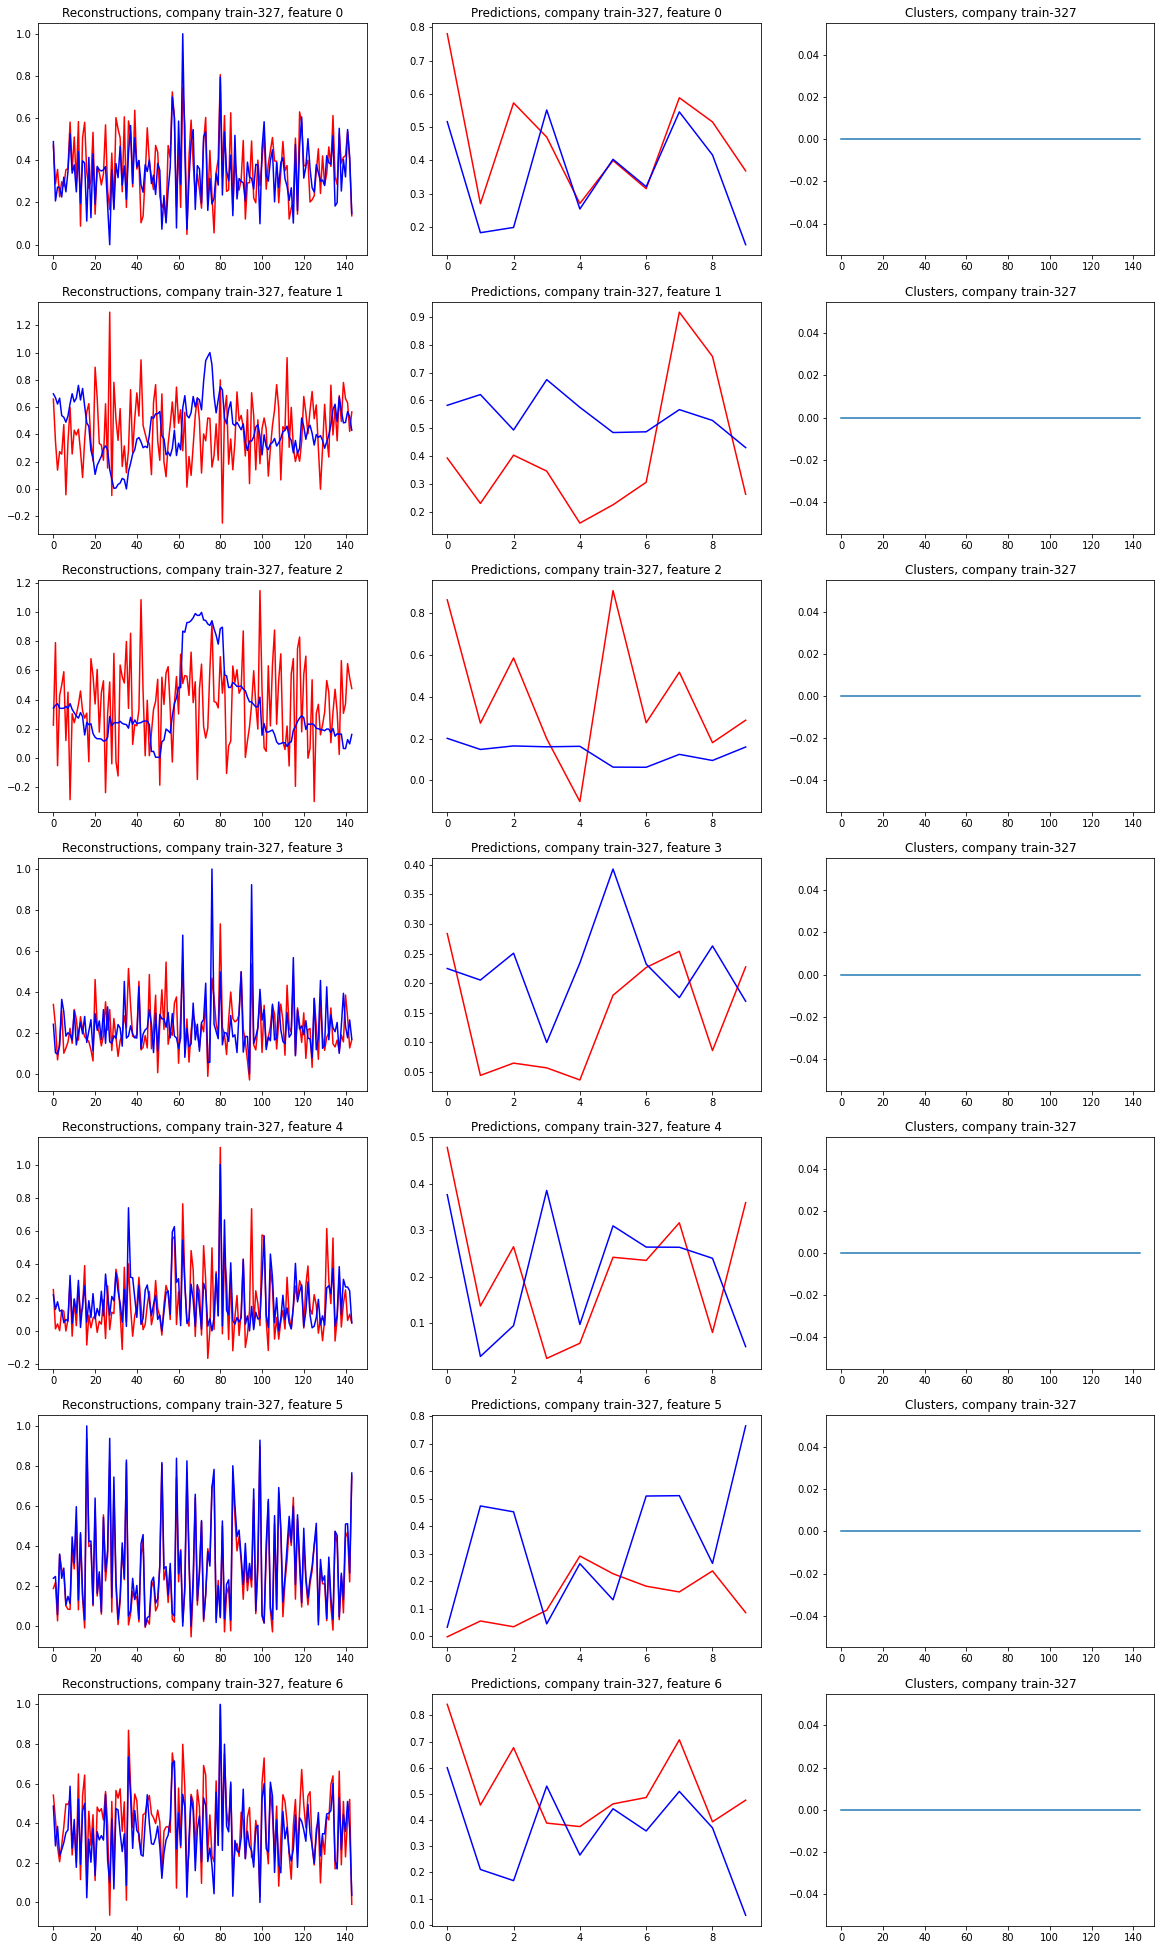

=================================== train, company 57 ====================================


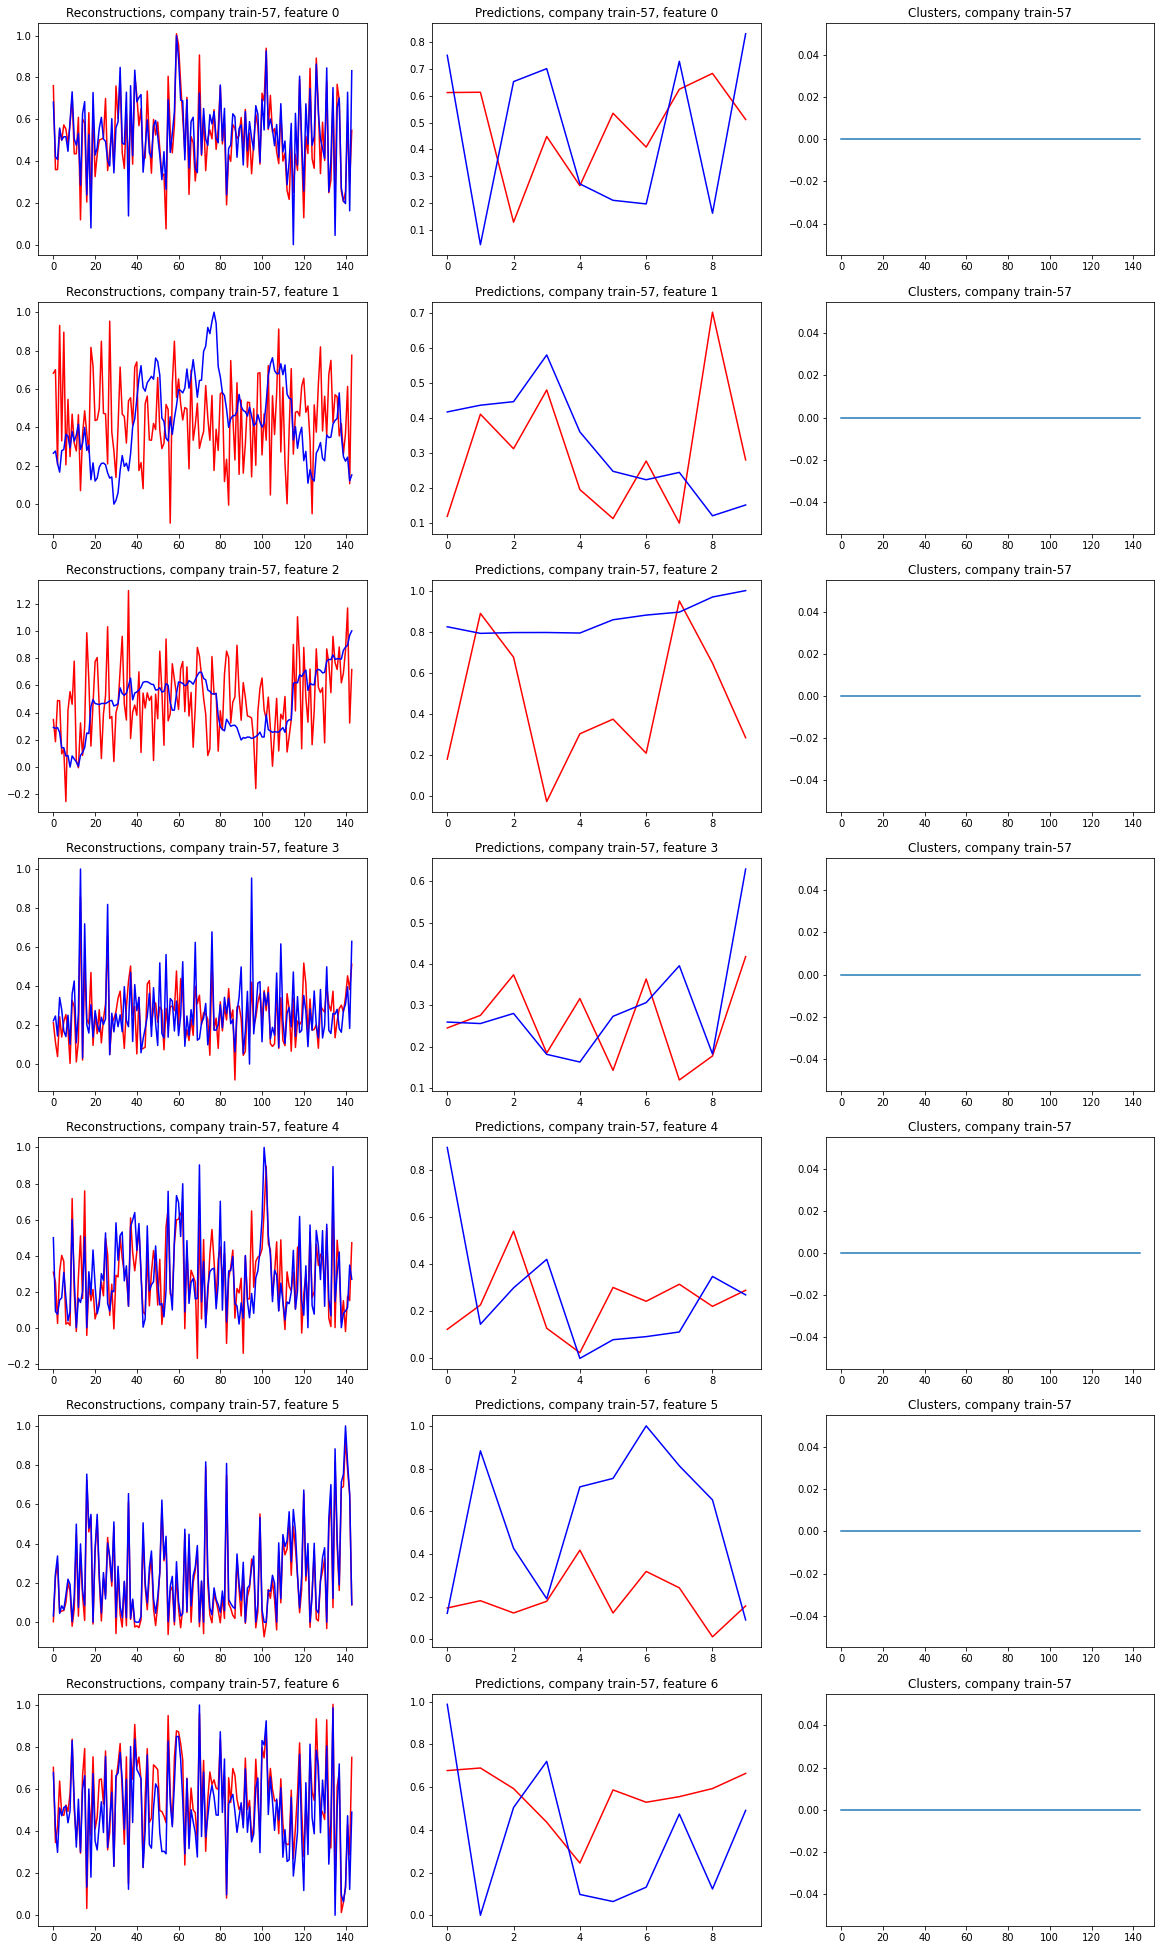

=================================== eval, company 3 ====================================


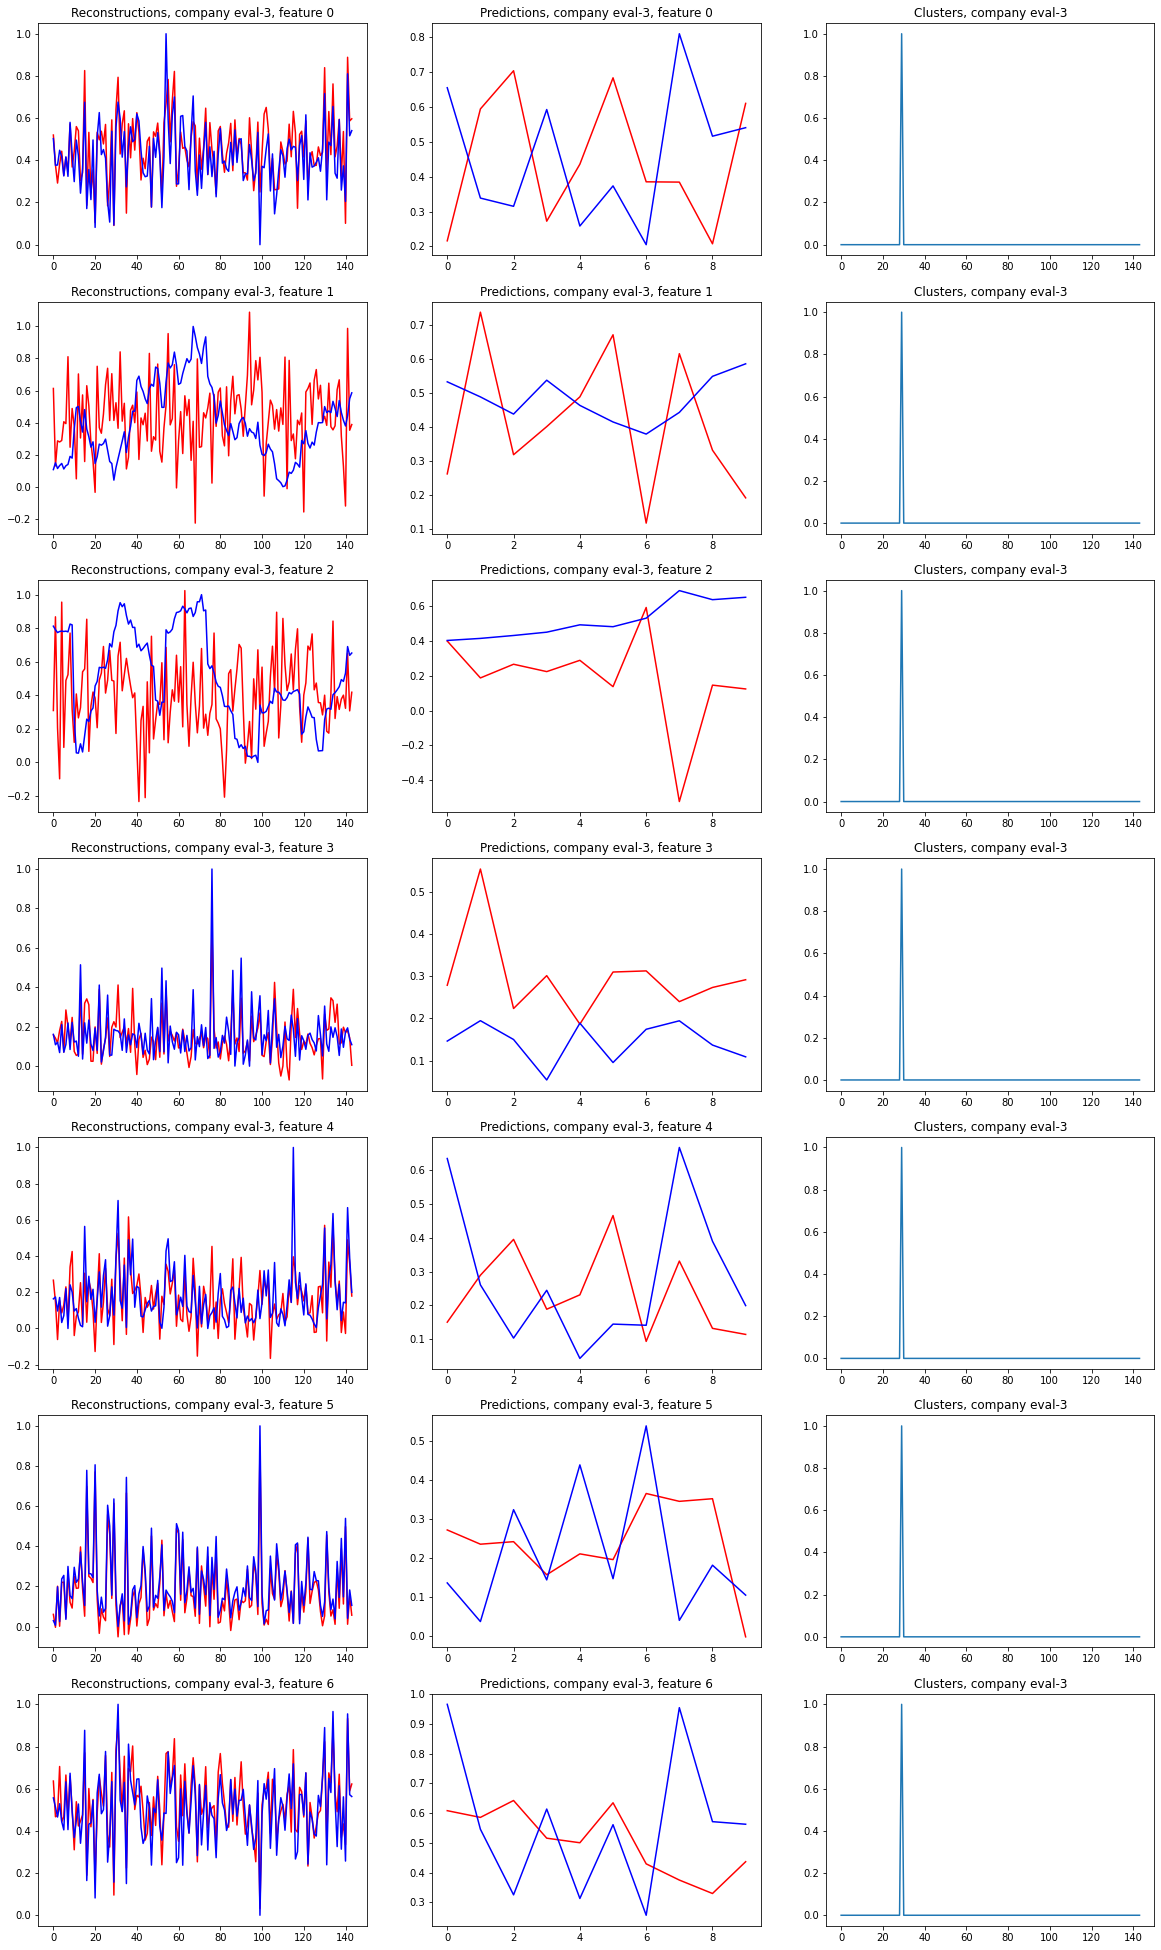

=================================== eval, company 35 ====================================


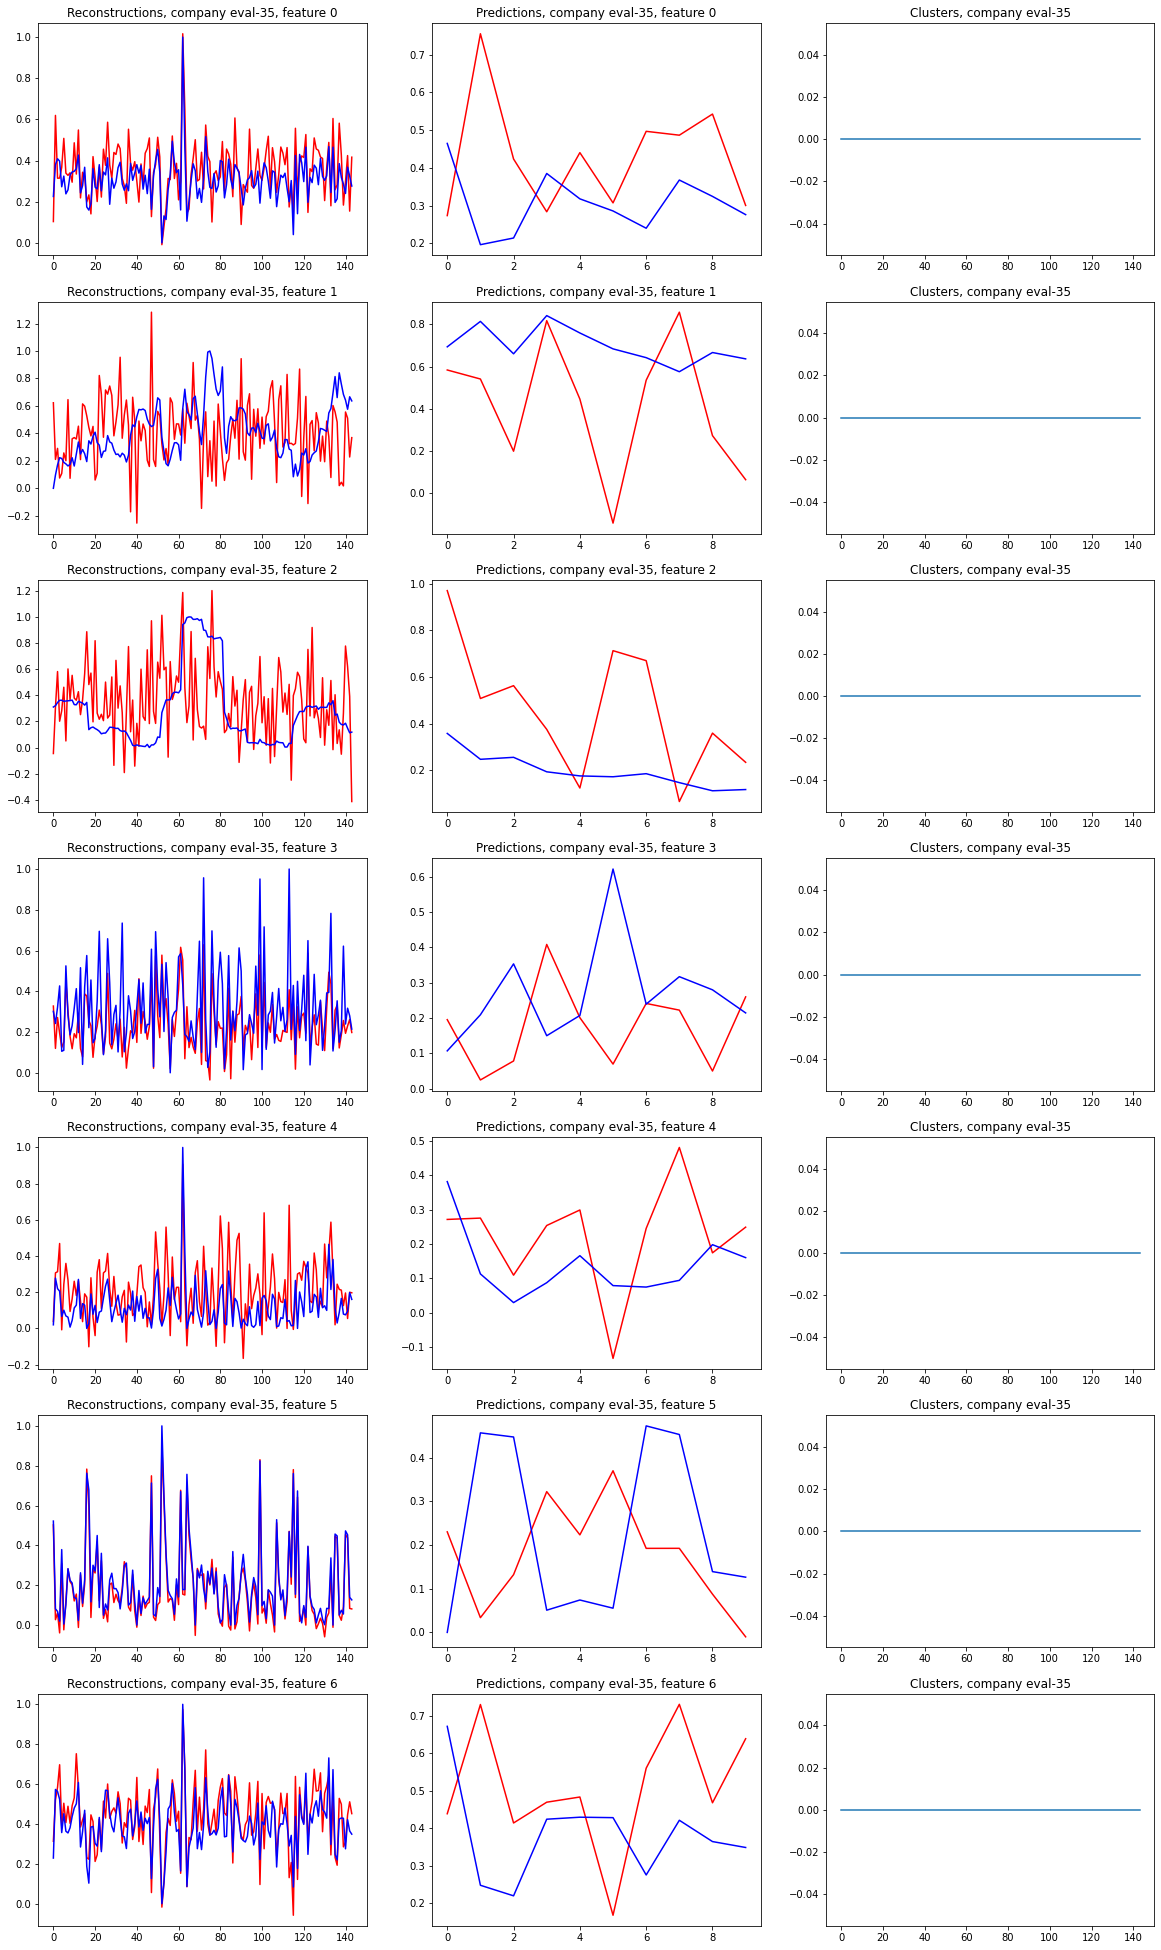

In [21]:
a, b = plot_tdpsom_results(data_train=data_train, data_eval=data_eval, EXP_NAME='hyperopt_LSTM_10_2-2_2021-03-22_9b098', N_companies=2, seed=42)